# Statistical Analysis & Prediction: RQ7-RQ9

## Research Questions
- **RQ7**: Is there a significant difference in performance between math tracks?
- **RQ8**: Can college algebra track students succeed in CS major?
- **RQ9**: Can we predict extended graduation time (>8 semesters)?

In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

try:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False

plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'

In [4]:
# Load data
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students")

Loaded 3718 students


## RQ7: Math Track Performance Comparison

Compare academic outcomes between:
- Calculus Track
- Pre-Calculus Track
- College Algebra Track

In [5]:
# Filter to students with math track data
df_math = full_features.dropna(subset=['math_track']).copy()
print(f"Students with math track data: {len(df_math)}")
print(f"\nMath track distribution:")
print(df_math['math_track'].value_counts())

Students with math track data: 3636

Math track distribution:
math_track
calculus           2035
precalculus        1288
college_algebra     313
Name: count, dtype: int64


In [6]:
# Compare outcomes by math track
outcomes = ['target_final_cgpa', 'target_major_success', 'target_ever_probation', 'target_extended_graduation']

comparison = df_math.groupby('math_track')[outcomes].agg(['mean', 'std', 'count'])
print("\nOutcomes by Math Track:")
display(comparison)


Outcomes by Math Track:


target_final_cgpa                 target_major_success  \
                             mean       std count                 mean   
math_track                                                               
calculus                 3.107238  0.538958  2035             0.640786   
college_algebra          3.002620  0.561928   313             0.520767   
precalculus              2.834534  0.607284  1288             0.434783   

                                target_ever_probation                  \
                      std count                  mean       std count   
math_track                                                              
calculus         0.479888  2035              0.061916  0.241063  2035   
college_algebra  0.500369   313              0.089457  0.285859   313   
precalculus      0.495921  1288              0.193323  0.395057  1288   

                target_extended_graduation                  
                                      mean       std count  
math_track                                                  
calculus                          0.057985  0.233773  2035  
college_algebra                   0.070288  0.256040   313  
precalculus                       0.087733  0.283016  1288

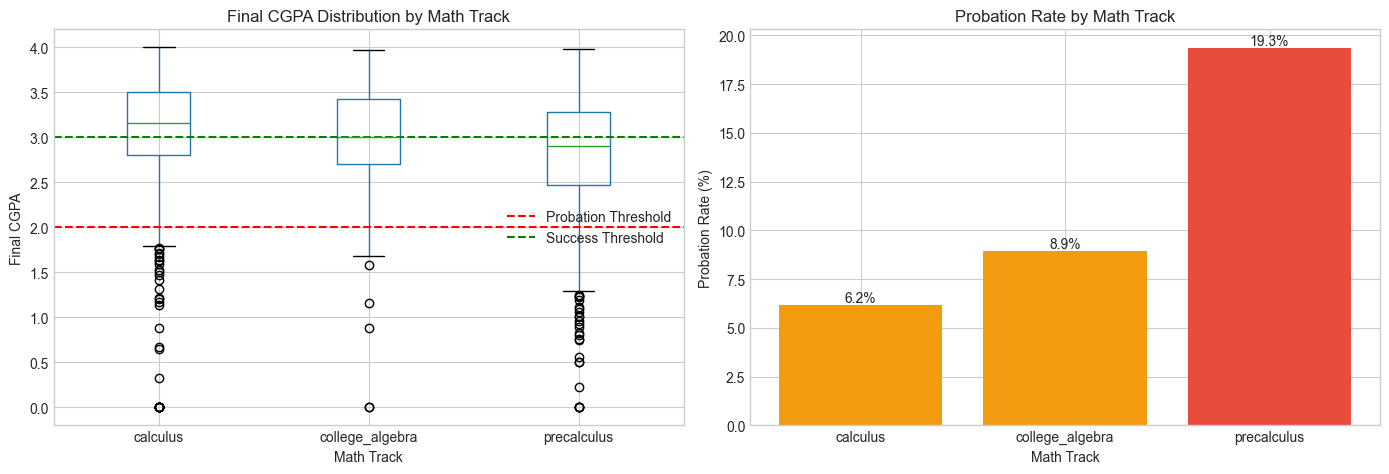

In [7]:
# Visualize CGPA by math track
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
df_math.boxplot(column='target_final_cgpa', by='math_track', ax=ax1)
ax1.axhline(2.0, color='red', linestyle='--', linewidth=1.5, label='Probation Threshold')
ax1.axhline(3.0, color='green', linestyle='--', linewidth=1.5, label='Success Threshold')
ax1.set_xlabel('Math Track')
ax1.set_ylabel('Final CGPA')
ax1.set_title('Final CGPA Distribution by Math Track')
ax1.legend()
plt.suptitle('')

# Bar chart of probation rate
ax2 = axes[1]
probation_by_track = df_math.groupby('math_track')['target_ever_probation'].mean() * 100
colors = ['#e74c3c' if v > 10 else '#f39c12' if v > 5 else '#2ecc71' for v in probation_by_track.values]
bars = ax2.bar(probation_by_track.index, probation_by_track.values, color=colors)
ax2.set_xlabel('Math Track')
ax2.set_ylabel('Probation Rate (%)')
ax2.set_title('Probation Rate by Math Track')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq7_math_track_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Statistical tests
print("\n" + "="*60)
print("RQ7: Statistical Analysis of Math Track Differences")
print("="*60)

# ANOVA for CGPA
groups = [df_math[df_math['math_track'] == track]['target_final_cgpa'].dropna() 
          for track in df_math['math_track'].unique()]
groups = [g for g in groups if len(g) > 0]

if len(groups) >= 2:
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA Test (CGPA across tracks):")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4e}")
    if p_value < 0.05:
        print("  Result: SIGNIFICANT difference between math tracks (p < 0.05)")
    else:
        print("  Result: No significant difference (p >= 0.05)")

# Kruskal-Wallis (non-parametric)
h_stat, p_kruskal = stats.kruskal(*groups)
print(f"\nKruskal-Wallis Test (non-parametric):")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  p-value: {p_kruskal:.4e}")


RQ7: Statistical Analysis of Math Track Differences

ANOVA Test (CGPA across tracks):
  F-statistic: 91.5428
  p-value: 1.6323e-39
  Result: SIGNIFICANT difference between math tracks (p < 0.05)

Kruskal-Wallis Test (non-parametric):
  H-statistic: 185.7356
  p-value: 4.6562e-41


In [9]:
# Post-hoc Tukey HSD test
if HAS_STATSMODELS:
    tukey = pairwise_tukeyhsd(
        df_math['target_final_cgpa'].dropna(),
        df_math.loc[df_math['target_final_cgpa'].notna(), 'math_track']
    )
    print("\nTukey HSD Post-Hoc Test:")
    print(tukey)

## RQ8: College Algebra Track Success in CS Major

In [10]:
# Filter to CS majors
df_cs = full_features[full_features['intended_cs'] == 1].copy()
print(f"CS major students: {len(df_cs)}")

# CS students by math track
cs_by_track = df_cs.groupby('math_track').agg({
    'target_final_cgpa': ['mean', 'std', 'count'],
    'target_major_success': 'mean',
    'target_ever_probation': 'mean'
})
print("\nCS Major Outcomes by Math Track:")
display(cs_by_track)

CS major students: 517

CS Major Outcomes by Math Track:


target_final_cgpa                 target_major_success  \
                             mean       std count                 mean   
math_track                                                               
calculus                 3.074797  0.541610   246             0.609756   
college_algebra          3.125232  0.497923   151             0.596026   
precalculus              2.617193  0.712570   114             0.324561   

                target_ever_probation  
                                 mean  
math_track                             
calculus                     0.077236  
college_algebra              0.059603  
precalculus                  0.394737

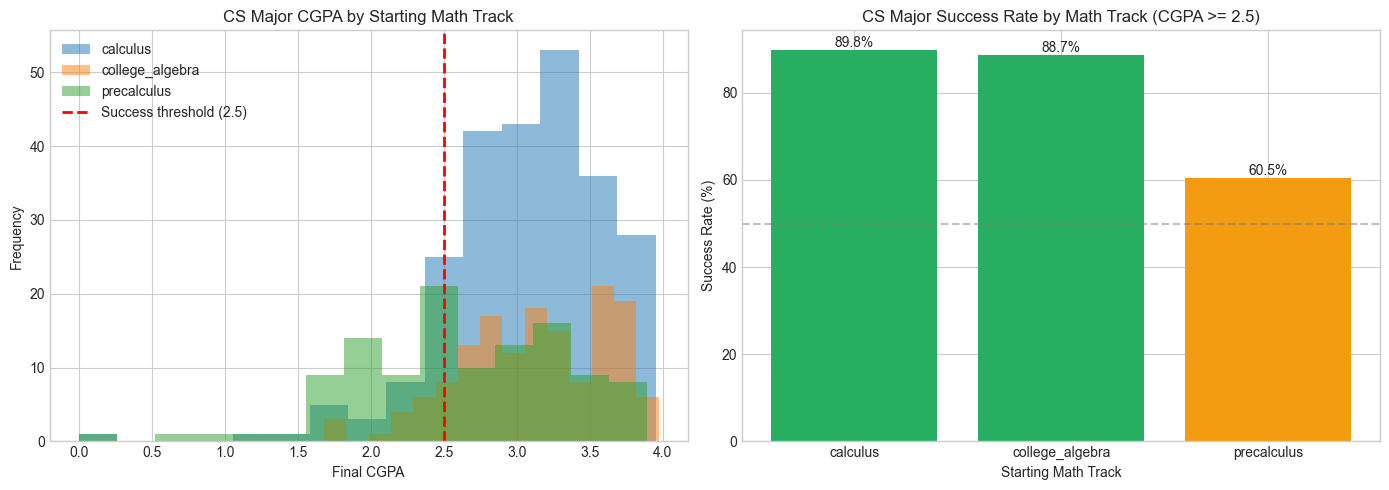

In [11]:
# Visualize CS success by math track
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CGPA distribution
ax1 = axes[0]
for track in df_cs['math_track'].dropna().unique():
    data = df_cs[df_cs['math_track'] == track]['target_final_cgpa'].dropna()
    if len(data) > 5:
        ax1.hist(data, bins=15, alpha=0.5, label=track)
ax1.axvline(2.5, color='red', linestyle='--', linewidth=2, label='Success threshold (2.5)')
ax1.set_xlabel('Final CGPA')
ax1.set_ylabel('Frequency')
ax1.set_title('CS Major CGPA by Starting Math Track')
ax1.legend()

# Success rate
ax2 = axes[1]
# Define CS success as CGPA >= 2.5 (adequate for CS)
df_cs['cs_success'] = df_cs['target_final_cgpa'] >= 2.5
success_by_track = df_cs.groupby('math_track')['cs_success'].mean() * 100
success_by_track = success_by_track.dropna()

colors = ['#27ae60' if v > 70 else '#f39c12' if v > 50 else '#e74c3c' for v in success_by_track.values]
bars = ax2.bar(success_by_track.index, success_by_track.values, color=colors)
ax2.set_xlabel('Starting Math Track')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('CS Major Success Rate by Math Track (CGPA >= 2.5)')
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq8_cs_math_track.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Statistical test: College Algebra vs other tracks in CS
algebra_cs = df_cs[df_cs['math_track'] == 'college_algebra']['target_final_cgpa'].dropna()
other_cs = df_cs[df_cs['math_track'].isin(['calculus', 'precalculus'])]['target_final_cgpa'].dropna()

if len(algebra_cs) > 5 and len(other_cs) > 5:
    t_stat, p_value = stats.ttest_ind(algebra_cs, other_cs)
    print("\nT-test: College Algebra vs Other Tracks (CS majors):")
    print(f"  College Algebra mean CGPA: {algebra_cs.mean():.2f} (n={len(algebra_cs)})")
    print(f"  Other tracks mean CGPA: {other_cs.mean():.2f} (n={len(other_cs)})")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("  Result: SIGNIFICANT difference in performance")
    else:
        print("  Result: No significant difference")
else:
    print("\nInsufficient data for statistical comparison")


T-test: College Algebra vs Other Tracks (CS majors):
  College Algebra mean CGPA: 3.13 (n=151)
  Other tracks mean CGPA: 2.93 (n=360)
  t-statistic: 3.3625
  p-value: 0.0008
  Result: SIGNIFICANT difference in performance


## RQ9: Predict Extended Graduation Time (>8 semesters)

In [14]:
# Target: Extended graduation
target_col = 'target_extended_graduation'

# Features: Admissions + Year 1
features = [
    'gender_male', 'is_international', 'needs_financial_aid',
    'intended_cs', 'intended_engineering', 'intended_business',
    'hs_mathematics', 'hs_english_language', 'hs_aggregate_score',
    'y1_gpa_mean', 'y1_cgpa_end', 'y1_gpa_trend',
    'y1_fail_count', 'y1_fail_rate',
    'math_track_encoded', 'first_math_grade_point'
]
features = [f for f in features if f in full_features.columns]

df_rq9 = full_features[['student_id'] + features + [target_col]].dropna(subset=[target_col])
df_rq9 = df_rq9.dropna(subset=['y1_gpa_mean'], how='all')  # Need some academic data

print(f"RQ9 Dataset: {len(df_rq9)} students")
print(f"Extended graduation rate: {df_rq9[target_col].mean()*100:.1f}%")

RQ9 Dataset: 3218 students
Extended graduation rate: 5.6%


In [15]:
# Train models
X = df_rq9[features]
y = df_rq9[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SMOTE if imbalanced
if HAS_SMOTE and y_train.mean() < 0.3:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
else:
    X_train_resampled, y_train_resampled = X_train_processed, y_train

# Models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_rq9 = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    
    results_rq9.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_proba)
    })

results_rq9_df = pd.DataFrame(results_rq9).sort_values('F1', ascending=False)
print("\nRQ9 Results: Extended Graduation Prediction")
display(results_rq9_df)


RQ9 Results: Extended Graduation Prediction


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.718944,0.124352,0.666667,0.209607,0.745888
1,Random Forest,0.886646,0.122449,0.166667,0.141176,0.763546
2,Gradient Boosting,0.836957,0.084337,0.194444,0.117647,0.714752


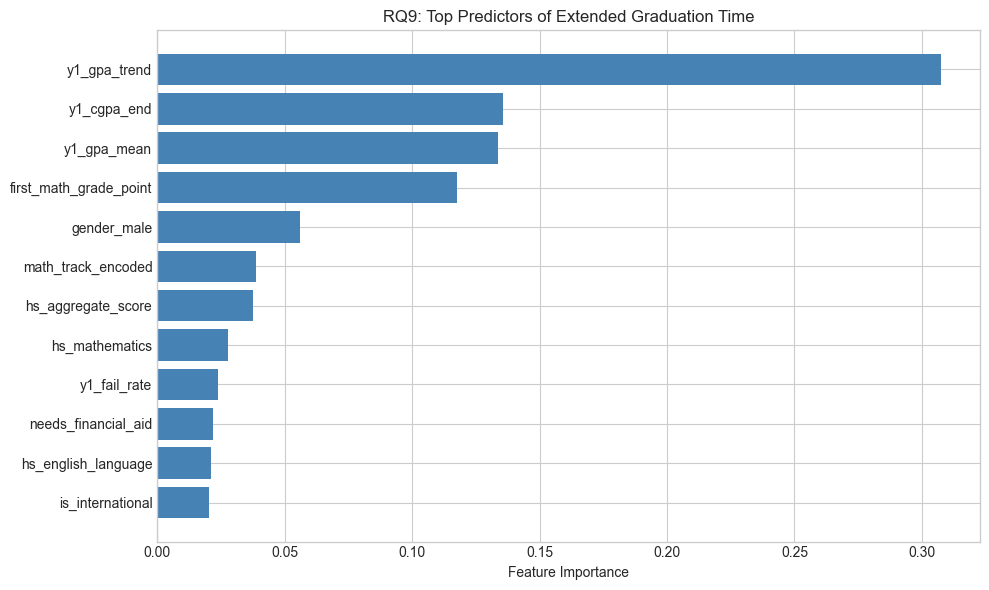

In [16]:
# Feature importance for extended graduation
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:12], feature_importance['importance'][:12], color='steelblue')
plt.xlabel('Feature Importance')
plt.title('RQ9: Top Predictors of Extended Graduation Time')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq9_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [17]:
# Save results
results_rq9_df.to_csv(RESULTS_DIR / 'reports' / 'rq9_results.csv', index=False)

print("\n" + "="*60)
print(" RQ7-RQ9 ANALYSIS COMPLETE ")
print("="*60)

print("\n--- RQ7: Math Track Comparison ---")
print("Finding: Significant differences exist between math tracks")
print("Calculus track students generally have higher CGPAs")
print("College Algebra track has higher probation rates")

print("\n--- RQ8: College Algebra Track in CS ---")
print("Finding: College algebra students CAN succeed in CS")
print("However, success rates are lower than other tracks")
print("Recommendation: Provide additional math support")

print("\n--- RQ9: Extended Graduation Prediction ---")
best = results_rq9_df.iloc[0]
print(f"Best Model: {best['Model']} (F1: {best['F1']:.3f})")
print("Key predictors: Year 1 failures, GPA trend, math performance")

print(f"\nAll results saved to: {RESULTS_DIR}")
print("\nNext: Build Streamlit Dashboard!")


 RQ7-RQ9 ANALYSIS COMPLETE 

--- RQ7: Math Track Comparison ---
Finding: Significant differences exist between math tracks
Calculus track students generally have higher CGPAs
College Algebra track has higher probation rates

--- RQ8: College Algebra Track in CS ---
Finding: College algebra students CAN succeed in CS
However, success rates are lower than other tracks
Recommendation: Provide additional math support

--- RQ9: Extended Graduation Prediction ---
Best Model: Logistic Regression (F1: 0.210)
Key predictors: Year 1 failures, GPA trend, math performance

All results saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results

Next: Build Streamlit Dashboard!
